In [19]:
import os
# os.environ['JAX_ENABLE_X64'] = 'True'
# import time
# time.sleep(1)
import jax.numpy as jnp
from xlron.environments.gn_model.isrs_gn_model import *
import jax.numpy as jnp
import chex
import numpy as np
from functools import partial
from scipy.constants import pi, h, c
from jax import numpy as jnp, jit
import jax
import matplotlib.pyplot as plt
from xlron.environments.env_funcs import init_transceiver_amplifier_noise_arrays

In [20]:
# Fixed parameters
ref_lambda = 1564e-9  # Reference wavelength [m]
nonlinear_coefficient = 1.2e-3  # Nonlinear coefficient [1/W^2]
raman_gain_slope = 0.028 / 1e3 / 1e12  # Raman gain slope [1/W/m/Hz]
attenuation = 0.2 / 4.343 / 1e3  # Attenuation [1/m]
attenuation_bar = 0.2 / 4.343 / 1e3  # Attenuation [1/m]
dispersion_coeff = 17 * 1e-12 / 1e-9 / 1e3  # Dispersion [s/m^2]
dispersion_slope = 0.067 * 1e-12 / 1e-18 / 1e3  # Dispersion slope [s/m^3]
roadm_loss = 6
total_bandwidth_hz = 15e12  # 15 THz

# Link parameters
num_spans = 10
span_length = 100e3  # 100 km per span

# Slot sizes to test [GHz]
slot_sizes = [150, 100, 50, 25, 12.5, 6.25, 3.125, 1.5625]

noise_data_path = "/Users/michaeldoherty/git/XLRON/xlron/data/gn_model/transceiver_amplifier_data.csv"
noise_data = {}
for slot_size in slot_sizes:
    num_channels = int(total_bandwidth_hz / (slot_size * 1e9))
    transceiver_snr, noise_figure = init_transceiver_amplifier_noise_arrays(num_channels, ref_lambda, slot_size, noise_data_path)
    noise_data[slot_size] = {"transceiver_snr": transceiver_snr, "noise_figure": noise_figure}

# Launch power sweep [dBm]
launch_powers = np.arange(22, 30, 0.25)  # 18 to 30 dBm in steps of 1


In [21]:
# Enhanced fiber transmission analysis with throughput calculations and power sweep

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def shannon_throughput(bandwidth_hz, snr_linear):
    """Calculate Shannon capacity: C = B * log2(1 + SNR)"""
    return bandwidth_hz * np.log2(1 + snr_linear)

# Storage for all results
all_results = {}
best_results = {}

print("Running analysis for all slot sizes and launch powers...")
print("=" * 60)

for slot_size in slot_sizes:
    print(f"\nAnalyzing slot size: {slot_size} GHz")
    transceiver_snr = noise_data[slot_size]["transceiver_snr"]
    noise_figure = noise_data[slot_size]["noise_figure"]

    # Calculate number of channels needed to fill 15 THz with this slot size
    num_channels = int(total_bandwidth_hz / (slot_size * 1e9))

    # Create channel grid
    ch_bandwidth = slot_size * 1e9  # Convert GHz to Hz

    # Center frequencies around reference frequency
    ref_freq = 3e8 / ref_lambda  # Reference frequency [Hz] (c = 3e8 m/s)

    # Symmetric spacing around reference frequency to cover 15 THz
    freq_spacing = slot_size * 1e9  # Hz
    ch_centre_freq = (jnp.arange(num_channels) - (num_channels - 1) / 2) * freq_spacing

    # Channel bandwidths
    ch_bandwidth_array = jnp.full((num_channels), ch_bandwidth)

    # Fixed arrays
    attenuation_array = jnp.full((num_channels), attenuation)
    attenuation_bar_array = jnp.full((num_channels), attenuation_bar)
    raman_array = jnp.full((num_channels), raman_gain_slope)
    length_array = jnp.full(num_spans, span_length)
    dispersion_array = jnp.array([dispersion_coeff])
    dispersion_slope_array = jnp.array([dispersion_slope])
    nonlinear_array = jnp.array([nonlinear_coefficient])
    excess_kurtosis = jnp.zeros_like(attenuation_array)

    slot_results = {}
    max_total_throughput = 0
    best_power = None

    for total_power_dbm in launch_powers:
        print(f"\nAnalyzing total power dbm: {total_power_dbm}")
        total_power_w = 10**(total_power_dbm/10) / 1000  # Convert dBm to W
        power_per_channel = total_power_w / num_channels

        # Channel powers
        ch_power = jnp.full((num_channels), power_per_channel)

        # Calculate SNR using your get_snr function
        # Note: You'll need to make sure get_snr, from_dbm, to_dbm, to_db functions are available
        try:
            snr, noise = get_snr(
                num_channels=num_channels,
                max_spans=num_spans,
                ref_lambda=ref_lambda,
                attenuation_i=attenuation_array,
                attenuation_bar_i=attenuation_bar_array,
                nonlinear_coeff=nonlinear_array,
                coherent=True,
                mod_format_correction=False,
                raman_gain_slope_i=raman_array,
                dispersion_coeff=dispersion_array,
                dispersion_slope=dispersion_slope_array,
                roadm_loss=roadm_loss,
                num_roadms=1,
                length=length_array,
                num_spans=num_spans,
                ch_power_w_i=ch_power,
                ch_centre_i=ch_centre_freq,
                ch_bandwidth_i=ch_bandwidth_array,
                amplifier_noise_figure=noise_figure,
                transceiver_snr=transceiver_snr,
                excess_kurtosis_i=excess_kurtosis,
            )

            # Unpack noise components
            eta_nli, eta_spm, eta_xpm, p_ase_inline, p_ase_roadm, p_nli, transceiver_noise = noise

            # Convert SNR to linear scale for throughput calculation
            snr_linear = 10**(np.array(snr) / 10)  # Convert from dB to linear

            # Calculate throughput for each channel
            channel_throughputs = shannon_throughput(ch_bandwidth, snr_linear)
            total_throughput = np.sum(channel_throughputs)

            # Store results
            slot_results[total_power_dbm] = {
                'num_channels': num_channels,
                'power_per_channel_dbm': 10 * np.log10(power_per_channel * 1000),  # Convert W to dBm
                'snr_db': np.array(snr),
                'snr_linear': snr_linear,
                'ch_centre_freq': np.array(ch_centre_freq) + c / ref_lambda,
                'eta_nli': np.array(eta_nli),
                'eta_spm': np.array(eta_spm),
                'eta_xpm': np.array(eta_xpm),
                'p_ase_inline': np.array(p_ase_inline),
                'p_ase_roadm': np.array(p_ase_roadm),
                'p_nli': np.array(p_nli),
                'transceiver_noise': np.array(transceiver_noise),
                'channel_throughputs_gbps': channel_throughputs / 1e9,  # Convert to Gbps
                'total_throughput_gbps': total_throughput / 1e9,  # Convert to Gbps
            }

            # Track best launch power for this slot size
            if total_throughput > max_total_throughput:
                max_total_throughput = total_throughput
                best_power = total_power_dbm

        except Exception as e:
            raise e
            print(f"  Error at {total_power_dbm} dBm: {e}")
            continue

    all_results[slot_size] = slot_results

    if best_power is not None:
        best_results[slot_size] = {
            'best_power_dbm': best_power,
            'max_throughput_gbps': max_total_throughput / 1e9,
            'best_data': slot_results[best_power]
        }
        print(f"  Best launch power: {best_power} dBm")
        print(f"  Max total throughput: {max_total_throughput/1e9:.1f} Gbps")
    else:
        print(f"  No valid results for slot size {slot_size} GHz")


Running analysis for all slot sizes and launch powers...

Analyzing slot size: 150 GHz

Analyzing total power dbm: 22.0

Analyzing total power dbm: 22.25

Analyzing total power dbm: 22.5

Analyzing total power dbm: 22.75

Analyzing total power dbm: 23.0

Analyzing total power dbm: 23.25

Analyzing total power dbm: 23.5

Analyzing total power dbm: 23.75

Analyzing total power dbm: 24.0

Analyzing total power dbm: 24.25

Analyzing total power dbm: 24.5

Analyzing total power dbm: 24.75

Analyzing total power dbm: 25.0

Analyzing total power dbm: 25.25

Analyzing total power dbm: 25.5

Analyzing total power dbm: 25.75

Analyzing total power dbm: 26.0

Analyzing total power dbm: 26.25

Analyzing total power dbm: 26.5

Analyzing total power dbm: 26.75

Analyzing total power dbm: 27.0

Analyzing total power dbm: 27.25

Analyzing total power dbm: 27.5

Analyzing total power dbm: 27.75

Analyzing total power dbm: 28.0

Analyzing total power dbm: 28.25

Analyzing total power dbm: 28.5

Analyzin

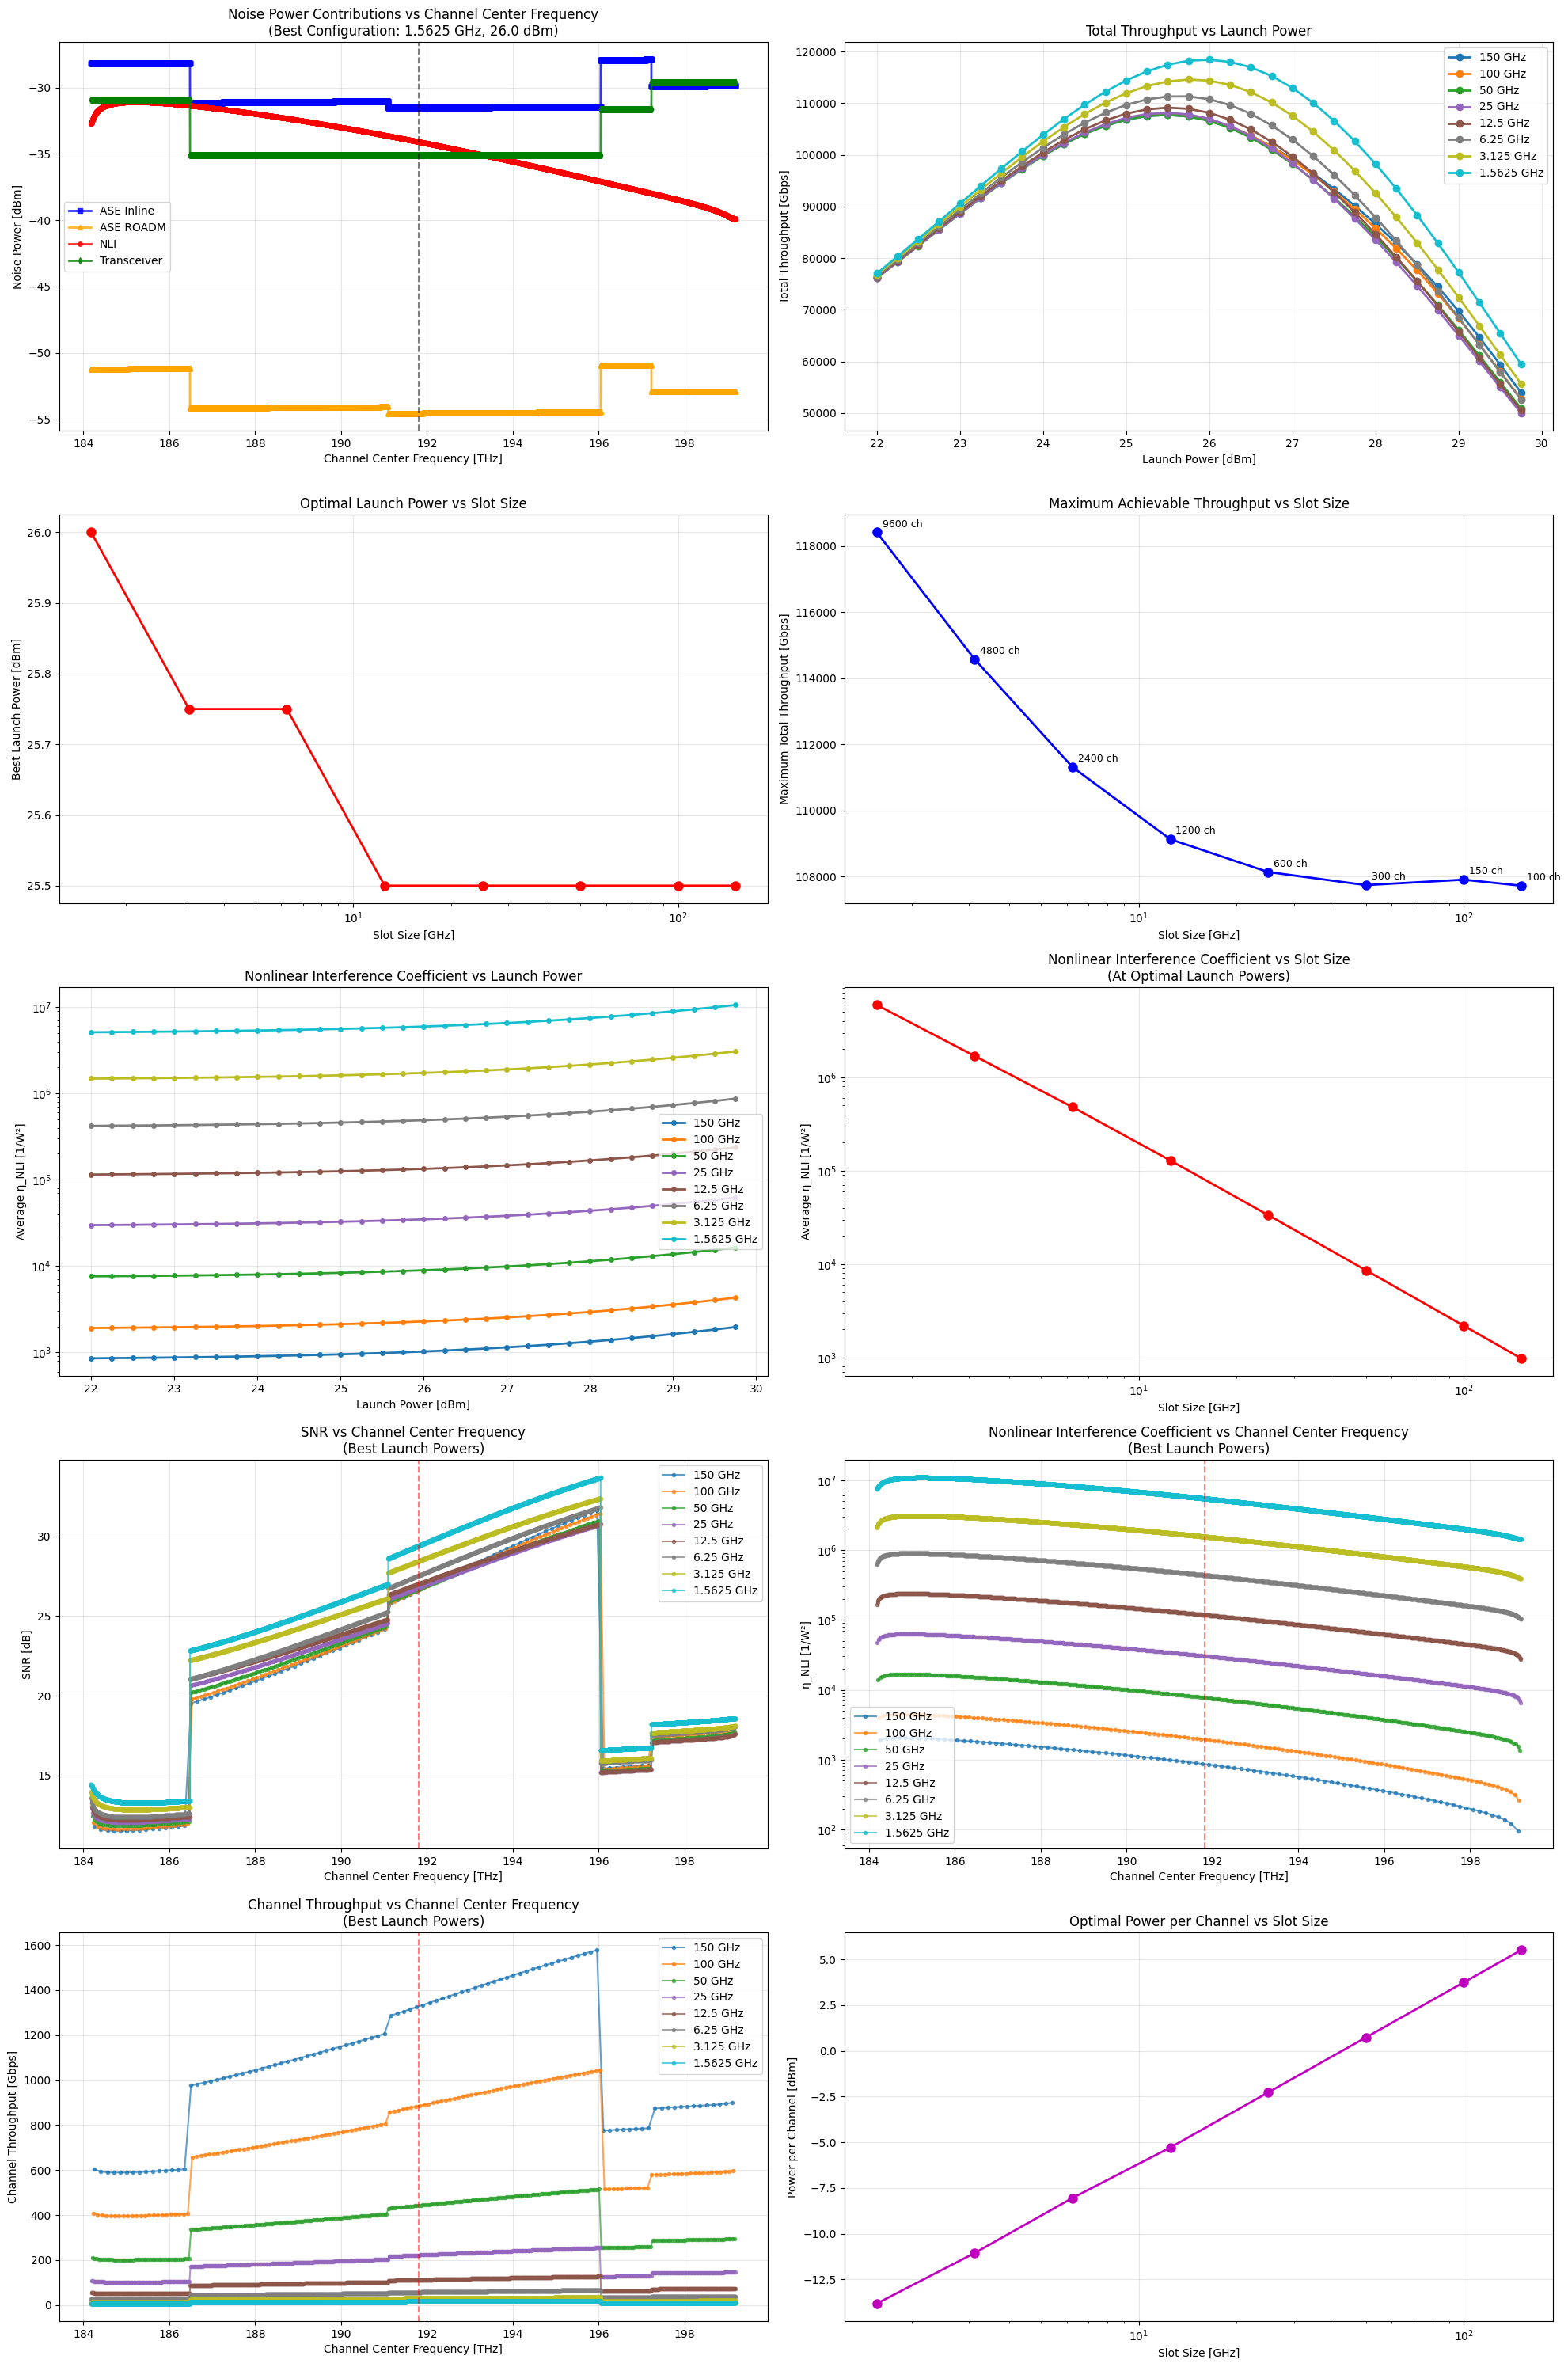

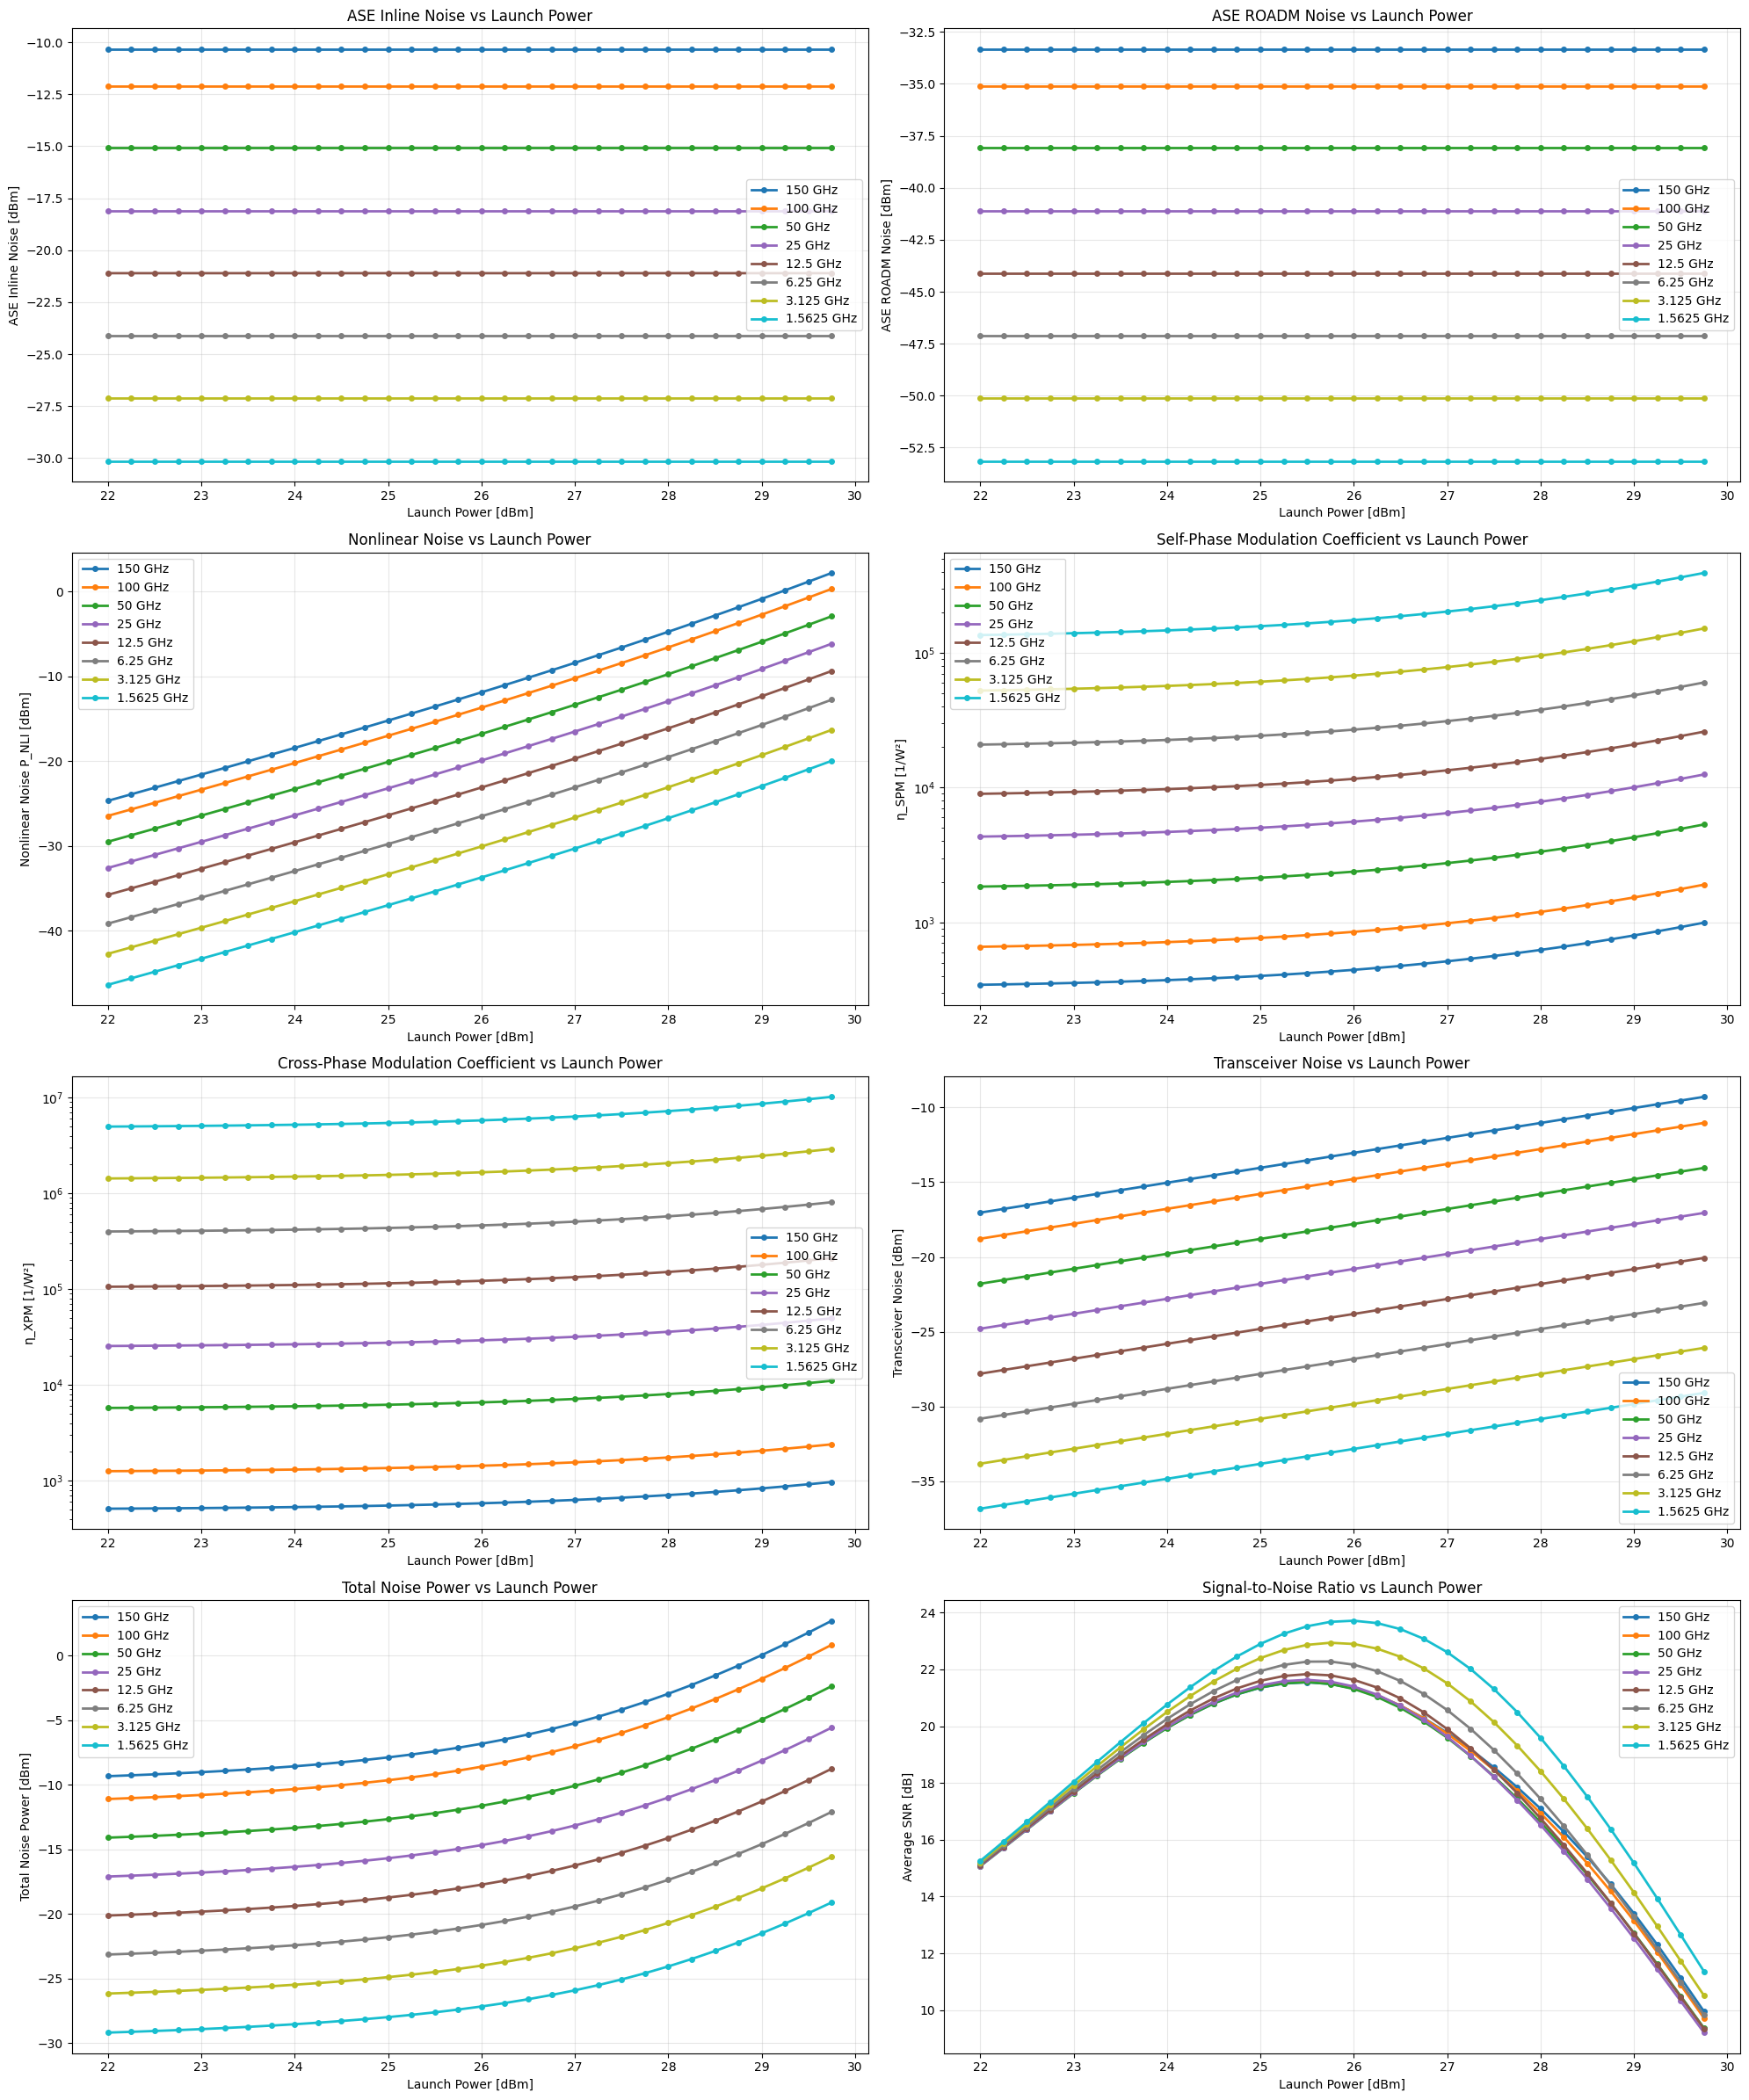


SUMMARY RESULTS
Slot Size | Channels | Best Power | Power/Ch | Max Throughput | Avg η_NLI  
   [GHz]  |    [-]   |   [dBm]    |  [dBm]   |     [Gbps]     | [1/W²]     
--------------------------------------------------------------------------------
 150.000 |      100 |       25.5 |      5.5 |       107720.5 | 9.83e+02
 100.000 |      150 |       25.5 |      3.7 |       107903.3 | 2.19e+03
  50.000 |      300 |       25.5 |      0.7 |       107738.1 | 8.62e+03
  25.000 |      600 |       25.5 |     -2.3 |       108134.4 | 3.36e+04
  12.500 |     1200 |       25.5 |     -5.3 |       109125.9 | 1.29e+05
   6.250 |     2400 |       25.8 |     -8.1 |       111310.1 | 4.81e+05
   3.125 |     4800 |       25.8 |    -11.1 |       114574.8 | 1.70e+06
   1.562 |     9600 |       26.0 |    -13.8 |       118412.7 | 5.96e+06

BEST OVERALL CONFIGURATION:
Slot Size: 1.5625 GHz
Number of Channels: 9600
Best Launch Power: 26.0 dBm
Maximum Throughput: 118412.7 Gbps


In [22]:
# Create comprehensive plots
fig1 = plt.figure(figsize=(20, 30))

# Plot 1: Noise Power Contributions vs Channel Center Frequency (best overall configuration)
ax1 = plt.subplot(5, 2, 1)

# Find the slot size with maximum throughput
if best_results:
    best_overall = max(best_results.items(), key=lambda x: x[1]['max_throughput_gbps'])
    best_slot_size = best_overall[0]
    best_data = best_overall[1]['best_data']

    freq_thz = best_data['ch_centre_freq'] / 1e12

    # Convert noise powers to dBm
    ase_inline_dbm = 10 * np.log10(best_data['p_ase_inline'] * 1000)
    ase_roadm_dbm = 10 * np.log10(best_data['p_ase_roadm'] * 1000)
    nli_dbm = 10 * np.log10(best_data['p_nli'] * 1000)
    trans_dbm = 10 * np.log10(best_data['transceiver_noise'] * 1000)

    # Plot different noise contributions with different colors and markers
    ax1.plot(freq_thz, ase_inline_dbm, 's-', color='blue', markersize=4,
            linewidth=2, alpha=0.8, label='ASE Inline')
    ax1.plot(freq_thz, ase_roadm_dbm, '^-', color='orange', markersize=4,
            linewidth=2, alpha=0.8, label='ASE ROADM')
    ax1.plot(freq_thz, nli_dbm, 'o-', color='red', markersize=4,
            linewidth=2, alpha=0.8, label='NLI')
    ax1.plot(freq_thz, trans_dbm, 'd-', color='green', markersize=4,
            linewidth=2, alpha=0.8, label='Transceiver')

ax1.set_xlabel('Channel Center Frequency [THz]')
ax1.set_ylabel('Noise Power [dBm]')
ax1.set_title(f'Noise Power Contributions vs Channel Center Frequency\n(Best Configuration: {best_slot_size} GHz, {best_overall[1]["best_power_dbm"]:.1f} dBm)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add reference wavelength line
ref_freq_thz = (3e8 / ref_lambda) / 1e12
ax1.axvline(ref_freq_thz, color='black', linestyle='--', alpha=0.5,
           label=f'Ref λ = {ref_lambda*1e9:.1f} nm')

# Plot 2: Total Throughput vs Launch Power for each slot size
ax2 = plt.subplot(5, 2, 2)
colors = plt.cm.tab10(np.linspace(0, 1, len(slot_sizes)))

for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        throughputs = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                throughputs.append(all_results[slot_size][power]['total_throughput_gbps'])

        if powers:
            ax2.plot(powers, throughputs, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

ax2.set_xlabel('Launch Power [dBm]')
ax2.set_ylabel('Total Throughput [Gbps]')
ax2.set_title('Total Throughput vs Launch Power')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Best Launch Power vs Slot Size
ax3 = plt.subplot(5, 2, 3)
slot_sizes_with_results = []
best_powers = []
for slot_size in slot_sizes:
    if slot_size in best_results:
        slot_sizes_with_results.append(slot_size)
        best_powers.append(best_results[slot_size]['best_power_dbm'])

if slot_sizes_with_results:
    ax3.semilogx(slot_sizes_with_results, best_powers, 'ro-', linewidth=2, markersize=8)
    ax3.set_xlabel('Slot Size [GHz]')
    ax3.set_ylabel('Best Launch Power [dBm]')
    ax3.set_title('Optimal Launch Power vs Slot Size')
    ax3.grid(True, alpha=0.3)

# Plot 4: Maximum Throughput vs Slot Size
ax4 = plt.subplot(5, 2, 4)
max_throughputs = []
for slot_size in slot_sizes_with_results:
    max_throughputs.append(best_results[slot_size]['max_throughput_gbps'])

if slot_sizes_with_results:
    ax4.semilogx(slot_sizes_with_results, max_throughputs, 'bo-', linewidth=2, markersize=8)
    # Add number of channels as annotations
    for slot_size, throughput in zip(slot_sizes_with_results, max_throughputs):
        num_ch = best_results[slot_size]['best_data']['num_channels']
        ax4.annotate(f'{num_ch} ch', (slot_size, throughput), xytext=(5, 5),
                    textcoords='offset points', fontsize=9)

    ax4.set_xlabel('Slot Size [GHz]')
    ax4.set_ylabel('Maximum Total Throughput [Gbps]')
    ax4.set_title('Maximum Achievable Throughput vs Slot Size')
    ax4.grid(True, alpha=0.3)

# Plot 5: eta_NLI vs Launch Power for each slot size
ax5 = plt.subplot(5, 2, 5)

for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        eta_nli_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Average eta_nli across all channels
                eta_nli_avg.append(np.mean(all_results[slot_size][power]['eta_nli']))

        if powers:
            ax5.semilogy(powers, eta_nli_avg, 'o-', color=colors[i],
                        label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax5.set_xlabel('Launch Power [dBm]')
ax5.set_ylabel('Average η_NLI [1/W²]')
ax5.set_title('Nonlinear Interference Coefficient vs Launch Power')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: eta_NLI vs Slot Size (at best launch powers)
ax6 = plt.subplot(5, 2, 6)
eta_nli_best = []
for slot_size in slot_sizes_with_results:
    data = best_results[slot_size]['best_data']
    eta_nli_best.append(np.mean(data['eta_nli']))

if slot_sizes_with_results:
    ax6.loglog(slot_sizes_with_results, eta_nli_best, 'ro-', linewidth=2, markersize=8)
    ax6.set_xlabel('Slot Size [GHz]')
    ax6.set_ylabel('Average η_NLI [1/W²]')
    ax6.set_title('Nonlinear Interference Coefficient vs Slot Size\n(At Optimal Launch Powers)')
    ax6.grid(True, alpha=0.3)

# Plot 7: SNR vs Channel Center Frequency (best launch powers)
ax7 = plt.subplot(5, 2, 7)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in best_results:
        data = best_results[slot_size]['best_data']
        freq_thz = data['ch_centre_freq'] / 1e12
        ax7.plot(freq_thz, data['snr_db'], 'o-',
                color=colors[i], markersize=3, alpha=0.7,
                label=f'{slot_size} GHz')

ax7.set_xlabel('Channel Center Frequency [THz]')
ax7.set_ylabel('SNR [dB]')
ax7.set_title('SNR vs Channel Center Frequency\n(Best Launch Powers)')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Add reference wavelength line
ref_freq_thz = (3e8 / ref_lambda) / 1e12
ax7.axvline(ref_freq_thz, color='red', linestyle='--', alpha=0.5,
           label=f'Ref λ = {ref_lambda*1e9:.1f} nm')

# Plot 8: eta_NLI vs Channel Center Frequency (best launch powers)
ax8 = plt.subplot(5, 2, 8)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in best_results:
        data = best_results[slot_size]['best_data']
        freq_thz = data['ch_centre_freq'] / 1e12
        ax8.semilogy(freq_thz, data['eta_nli'], 'o-',
                    color=colors[i], markersize=3, alpha=0.7,
                    label=f'{slot_size} GHz')

ax8.set_xlabel('Channel Center Frequency [THz]')
ax8.set_ylabel('η_NLI [1/W²]')
ax8.set_title('Nonlinear Interference Coefficient vs Channel Center Frequency\n(Best Launch Powers)')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Add reference wavelength line
ax8.axvline(ref_freq_thz, color='red', linestyle='--', alpha=0.5)

# Plot 9: Throughput vs Channel Center Frequency (best launch powers)
ax9 = plt.subplot(5, 2, 9)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in best_results:
        data = best_results[slot_size]['best_data']
        freq_thz = data['ch_centre_freq'] / 1e12
        ax9.plot(freq_thz, data['channel_throughputs_gbps'], 'o-',
                color=colors[i], markersize=3, alpha=0.7,
                label=f'{slot_size} GHz')

ax9.set_xlabel('Channel Center Frequency [THz]')
ax9.set_ylabel('Channel Throughput [Gbps]')
ax9.set_title('Channel Throughput vs Channel Center Frequency\n(Best Launch Powers)')
ax9.legend()
ax9.grid(True, alpha=0.3)

# Add reference wavelength line
ax9.axvline(ref_freq_thz, color='red', linestyle='--', alpha=0.5)

# Plot 10: Power per Channel vs Slot Size (at best launch power)
ax10 = plt.subplot(5, 2, 10)
power_per_channels = []
for slot_size in slot_sizes_with_results:
    power_per_channels.append(best_results[slot_size]['best_data']['power_per_channel_dbm'])

if slot_sizes_with_results:
    ax10.semilogx(slot_sizes_with_results, power_per_channels, 'mo-', linewidth=2, markersize=8)
    ax10.set_xlabel('Slot Size [GHz]')
    ax10.set_ylabel('Power per Channel [dBm]')
    ax10.set_title('Optimal Power per Channel vs Slot Size')
    ax10.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create noise analysis plots
fig2 = plt.figure(figsize=(20, 24))

# Plot 1: ASE Inline Noise vs Launch Power
ax_ase_inline = plt.subplot(4, 2, 1)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        ase_inline_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Convert to dBm and average across channels
                ase_inline_dbm = 10 * np.log10(np.mean(all_results[slot_size][power]['p_ase_inline']) * 1000)
                ase_inline_avg.append(ase_inline_dbm)

        if powers:
            ax_ase_inline.plot(powers, ase_inline_avg, 'o-', color=colors[i],
                              label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_ase_inline.set_xlabel('Launch Power [dBm]')
ax_ase_inline.set_ylabel('ASE Inline Noise [dBm]')
ax_ase_inline.set_title('ASE Inline Noise vs Launch Power')
ax_ase_inline.legend()
ax_ase_inline.grid(True, alpha=0.3)

# Plot 2: ASE ROADM Noise vs Launch Power
ax_ase_roadm = plt.subplot(4, 2, 2)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        ase_roadm_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Convert to dBm and average across channels
                ase_roadm_dbm = 10 * np.log10(np.mean(all_results[slot_size][power]['p_ase_roadm']) * 1000)
                ase_roadm_avg.append(ase_roadm_dbm)

        if powers:
            ax_ase_roadm.plot(powers, ase_roadm_avg, 'o-', color=colors[i],
                             label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_ase_roadm.set_xlabel('Launch Power [dBm]')
ax_ase_roadm.set_ylabel('ASE ROADM Noise [dBm]')
ax_ase_roadm.set_title('ASE ROADM Noise vs Launch Power')
ax_ase_roadm.legend()
ax_ase_roadm.grid(True, alpha=0.3)

# Plot 3: Nonlinear Noise (P_NLI) vs Launch Power
ax_nli = plt.subplot(4, 2, 3)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        nli_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Convert to dBm and average across channels
                nli_dbm = 10 * np.log10(np.mean(all_results[slot_size][power]['p_nli']) * 1000)
                nli_avg.append(nli_dbm)

        if powers:
            ax_nli.plot(powers, nli_avg, 'o-', color=colors[i],
                       label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_nli.set_xlabel('Launch Power [dBm]')
ax_nli.set_ylabel('Nonlinear Noise P_NLI [dBm]')
ax_nli.set_title('Nonlinear Noise vs Launch Power')
ax_nli.legend()
ax_nli.grid(True, alpha=0.3)

# Plot 4: eta_SPM vs Launch Power
ax_spm = plt.subplot(4, 2, 4)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        spm_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Average across channels
                spm_avg.append(np.mean(all_results[slot_size][power]['eta_spm']))

        if powers:
            ax_spm.semilogy(powers, spm_avg, 'o-', color=colors[i],
                           label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_spm.set_xlabel('Launch Power [dBm]')
ax_spm.set_ylabel('η_SPM [1/W²]')
ax_spm.set_title('Self-Phase Modulation Coefficient vs Launch Power')
ax_spm.legend()
ax_spm.grid(True, alpha=0.3)

# Plot 5: eta_XPM vs Launch Power
ax_xpm = plt.subplot(4, 2, 5)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        xpm_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Average across channels
                xpm_avg.append(np.mean(all_results[slot_size][power]['eta_xpm']))

        if powers:
            ax_xpm.semilogy(powers, xpm_avg, 'o-', color=colors[i],
                           label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_xpm.set_xlabel('Launch Power [dBm]')
ax_xpm.set_ylabel('η_XPM [1/W²]')
ax_xpm.set_title('Cross-Phase Modulation Coefficient vs Launch Power')
ax_xpm.legend()
ax_xpm.grid(True, alpha=0.3)

# Plot 6: Transceiver Noise vs Launch Power
ax_trans = plt.subplot(4, 2, 6)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        trans_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Convert to dBm and average across channels
                trans_dbm = 10 * np.log10(np.mean(all_results[slot_size][power]['transceiver_noise']) * 1000)
                trans_avg.append(trans_dbm)

        if powers:
            ax_trans.plot(powers, trans_avg, 'o-', color=colors[i],
                         label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_trans.set_xlabel('Launch Power [dBm]')
ax_trans.set_ylabel('Transceiver Noise [dBm]')
ax_trans.set_title('Transceiver Noise vs Launch Power')
ax_trans.legend()
ax_trans.grid(True, alpha=0.3)

# Plot 7: Total Noise Power vs Launch Power
ax_total_noise = plt.subplot(4, 2, 7)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        total_noise_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Calculate total noise power (sum of all noise sources)
                data = all_results[slot_size][power]
                total_noise = (data['p_ase_inline'] + data['p_ase_roadm'] +
                              data['p_nli'] + data['transceiver_noise'])
                total_noise_dbm = 10 * np.log10(np.mean(total_noise) * 1000)
                total_noise_avg.append(total_noise_dbm)

        if powers:
            ax_total_noise.plot(powers, total_noise_avg, 'o-', color=colors[i],
                               label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_total_noise.set_xlabel('Launch Power [dBm]')
ax_total_noise.set_ylabel('Total Noise Power [dBm]')
ax_total_noise.set_title('Total Noise Power vs Launch Power')
ax_total_noise.legend()
ax_total_noise.grid(True, alpha=0.3)

# Plot 8: Signal-to-Noise Ratio vs Launch Power
ax_snr_power = plt.subplot(4, 2, 8)
for i, slot_size in enumerate(slot_sizes):
    if slot_size in all_results:
        powers = []
        snr_avg = []
        for power in launch_powers:
            if power in all_results[slot_size]:
                powers.append(power)
                # Average SNR across channels
                snr_avg.append(np.mean(all_results[slot_size][power]['snr_db']))

        if powers:
            ax_snr_power.plot(powers, snr_avg, 'o-', color=colors[i],
                             label=f'{slot_size} GHz', linewidth=2, markersize=4)

ax_snr_power.set_xlabel('Launch Power [dBm]')
ax_snr_power.set_ylabel('Average SNR [dB]')
ax_snr_power.set_title('Signal-to-Noise Ratio vs Launch Power')
ax_snr_power.legend()
ax_snr_power.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print("SUMMARY RESULTS")
print("="*80)
print("Slot Size | Channels | Best Power | Power/Ch | Max Throughput | Avg η_NLI  ")
print("   [GHz]  |    [-]   |   [dBm]    |  [dBm]   |     [Gbps]     | [1/W²]     ")
print("-"*80)

for slot_size in slot_sizes:
    if slot_size in best_results:
        data = best_results[slot_size]['best_data']
        avg_eta_nli = np.mean(data['eta_nli'])

        print(f"{slot_size:8.3f} | {data['num_channels']:8d} | {best_results[slot_size]['best_power_dbm']:10.1f} | "
              f"{data['power_per_channel_dbm']:8.1f} | {best_results[slot_size]['max_throughput_gbps']:14.1f} | "
              f"{avg_eta_nli:.2e}")
    else:
        print(f"{slot_size:8.3f} | {'N/A':>8s} | {'N/A':>10s} | {'N/A':>8s} | {'N/A':>14s} | {'N/A':>10s}")

print("="*80)

# Find overall best configuration
if best_results:
    best_overall = max(best_results.items(), key=lambda x: x[1]['max_throughput_gbps'])
    print(f"\nBEST OVERALL CONFIGURATION:")
    print(f"Slot Size: {best_overall[0]} GHz")
    print(f"Number of Channels: {best_overall[1]['best_data']['num_channels']}")
    print(f"Best Launch Power: {best_overall[1]['best_power_dbm']} dBm")
    print(f"Maximum Throughput: {best_overall[1]['max_throughput_gbps']:.1f} Gbps")

In [23]:
# Enhanced fiber transmission analysis with throughput calculations, power sweep, and span sweep

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def shannon_throughput(bandwidth_hz, snr_linear):
    """Calculate Shannon capacity: C = B * log2(1 + SNR)"""
    return bandwidth_hz * np.log2(1 + snr_linear)

# Define span configurations to test
span_configurations = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

# Storage for all results - now organized by num_spans, then slot_size
all_results = {}
best_results = {}

print("Running analysis for all span configurations, slot sizes and launch powers...")
print("=" * 80)

for num_spans_config in span_configurations:
    print(f"\n{'='*80}")
    print(f"ANALYZING SPAN CONFIGURATION: {num_spans_config} spans")
    print(f"{'='*80}")

    span_results = {}
    span_best_results = {}

    for slot_size in slot_sizes:
        print(f"\n  Analyzing slot size: {slot_size} GHz")
        transceiver_snr = noise_data[slot_size]["transceiver_snr"]
        noise_figure = noise_data[slot_size]["noise_figure"]

        # Calculate number of channels needed to fill 15 THz with this slot size
        num_channels = int(total_bandwidth_hz / (slot_size * 1e9))

        # Create channel grid
        ch_bandwidth = slot_size * 1e9  # Convert GHz to Hz

        # Center frequencies around reference frequency
        ref_freq = 3e8 / ref_lambda  # Reference frequency [Hz] (c = 3e8 m/s)

        # Symmetric spacing around reference frequency to cover 15 THz
        freq_spacing = slot_size * 1e9  # Hz
        ch_centre_freq = (jnp.arange(num_channels) - (num_channels - 1) / 2) * freq_spacing

        # Channel bandwidths
        ch_bandwidth_array = jnp.full((num_channels), ch_bandwidth)

        # Fixed arrays
        attenuation_array = jnp.full((num_channels), attenuation)
        attenuation_bar_array = jnp.full((num_channels), attenuation_bar)
        raman_array = jnp.full((num_channels), raman_gain_slope)
        length_array = jnp.full(num_spans_config, span_length)  # Use current span configuration
        dispersion_array = jnp.array([dispersion_coeff])
        dispersion_slope_array = jnp.array([dispersion_slope])
        nonlinear_array = jnp.array([nonlinear_coefficient])
        excess_kurtosis = jnp.zeros_like(attenuation_array)

        slot_results = {}
        max_total_throughput = 0
        best_power = None

        for total_power_dbm in launch_powers:
            print(f"    Analyzing total power: {total_power_dbm} dBm")
            total_power_w = 10**(total_power_dbm/10) / 1000  # Convert dBm to W
            power_per_channel = total_power_w / num_channels

            # Channel powers
            ch_power = jnp.full((num_channels), power_per_channel)

            # Calculate SNR using your get_snr function
            try:
                snr, noise = get_snr(
                    num_channels=num_channels,
                    max_spans=num_spans_config,  # Use current span configuration
                    ref_lambda=ref_lambda,
                    attenuation_i=attenuation_array,
                    attenuation_bar_i=attenuation_bar_array,
                    nonlinear_coeff=nonlinear_array,
                    coherent=True,
                    mod_format_correction=False,
                    raman_gain_slope_i=raman_array,
                    dispersion_coeff=dispersion_array,
                    dispersion_slope=dispersion_slope_array,
                    roadm_loss=roadm_loss,
                    num_roadms=1,
                    length=length_array,
                    num_spans=num_spans_config,  # Use current span configuration
                    ch_power_w_i=ch_power,
                    ch_centre_i=ch_centre_freq,
                    ch_bandwidth_i=ch_bandwidth_array,
                    amplifier_noise_figure=noise_figure,
                    transceiver_snr=transceiver_snr,
                    excess_kurtosis_i=excess_kurtosis,
                )

                # Unpack noise components
                eta_nli, eta_spm, eta_xpm, p_ase_inline, p_ase_roadm, p_nli, transceiver_noise = noise

                # Convert SNR to linear scale for throughput calculation
                snr_linear = 10**(np.array(snr) / 10)  # Convert from dB to linear

                # Calculate throughput for each channel
                channel_throughputs = shannon_throughput(ch_bandwidth, snr_linear)
                total_throughput = np.sum(channel_throughputs)

                # Store results
                slot_results[total_power_dbm] = {
                    'num_spans': num_spans_config,
                    'num_channels': num_channels,
                    'power_per_channel_dbm': 10 * np.log10(power_per_channel * 1000),  # Convert W to dBm
                    'snr_db': np.array(snr),
                    'snr_linear': snr_linear,
                    'ch_centre_freq': np.array(ch_centre_freq) + c / ref_lambda,
                    'eta_nli': np.array(eta_nli),
                    'eta_spm': np.array(eta_spm),
                    'eta_xpm': np.array(eta_xpm),
                    'p_ase_inline': np.array(p_ase_inline),
                    'p_ase_roadm': np.array(p_ase_roadm),
                    'p_nli': np.array(p_nli),
                    'transceiver_noise': np.array(transceiver_noise),
                    'channel_throughputs_gbps': channel_throughputs / 1e9,  # Convert to Gbps
                    'total_throughput_gbps': total_throughput / 1e9,  # Convert to Gbps
                    'total_distance_km': num_spans_config * span_length,  # Total link distance
                }

                # Track best launch power for this slot size and span configuration
                if total_throughput > max_total_throughput:
                    max_total_throughput = total_throughput
                    best_power = total_power_dbm

            except Exception as e:
                print(f"    Error at {total_power_dbm} dBm: {e}")
                continue

        span_results[slot_size] = slot_results

        if best_power is not None:
            span_best_results[slot_size] = {
                'num_spans': num_spans_config,
                'best_power_dbm': best_power,
                'max_throughput_gbps': max_total_throughput / 1e9,
                'total_distance_km': num_spans_config * span_length,
                'best_data': slot_results[best_power]
            }
            print(f"    Best launch power: {best_power} dBm")
            print(f"    Max total throughput: {max_total_throughput/1e9:.1f} Gbps")
            print(f"    Total distance: {num_spans_config * span_length} km")
        else:
            print(f"    No valid results for slot size {slot_size} GHz")

    # Store results for this span configuration
    all_results[num_spans_config] = span_results
    best_results[num_spans_config] = span_best_results

    # Print summary for this span configuration
    print(f"\n  SUMMARY for {num_spans_config} spans:")
    print(f"  Total distance: {num_spans_config * span_length} km")
    if span_best_results:
        best_slot = max(span_best_results.keys(),
                       key=lambda k: span_best_results[k]['max_throughput_gbps'])
        print(f"  Best slot size: {best_slot} GHz")
        print(f"  Best throughput: {span_best_results[best_slot]['max_throughput_gbps']:.1f} Gbps")
        print(f"  Best power: {span_best_results[best_slot]['best_power_dbm']} dBm")
    else:
        print(f"  No valid results for any slot size")

print(f"\n{'='*80}")
print("FINAL SUMMARY - Best configuration across all spans:")
print(f"{'='*80}")

# Find overall best configuration
overall_best_throughput = 0
overall_best_config = None

for num_spans_config in span_configurations:
    if num_spans_config in best_results:
        for slot_size in best_results[num_spans_config]:
            throughput = best_results[num_spans_config][slot_size]['max_throughput_gbps']
            if throughput > overall_best_throughput:
                overall_best_throughput = throughput
                overall_best_config = {
                    'num_spans': num_spans_config,
                    'slot_size': slot_size,
                    'distance_km': num_spans_config * span_length,
                    'throughput_gbps': throughput,
                    'power_dbm': best_results[num_spans_config][slot_size]['best_power_dbm']
                }

if overall_best_config:
    print(f"Best configuration:")
    print(f"  Spans: {overall_best_config['num_spans']}")
    print(f"  Distance: {overall_best_config['distance_km']} m")
    print(f"  Slot size: {overall_best_config['slot_size']} GHz")
    print(f"  Launch power: {overall_best_config['power_dbm']} dBm")
    print(f"  Max throughput: {overall_best_config['throughput_gbps']:.1f} Gbps")
else:
    print("No valid configurations found")

print(f"\nAnalysis complete!")
print(f"Results stored in:")
print(f"  all_results[num_spans][slot_size][power_dbm] - detailed results")
print(f"  best_results[num_spans][slot_size] - best results per span/slot combination")

Running analysis for all span configurations, slot sizes and launch powers...

ANALYZING SPAN CONFIGURATION: 1 spans

  Analyzing slot size: 150 GHz
    Analyzing total power: 22.0 dBm
    Analyzing total power: 22.25 dBm
    Analyzing total power: 22.5 dBm
    Analyzing total power: 22.75 dBm
    Analyzing total power: 23.0 dBm
    Analyzing total power: 23.25 dBm
    Analyzing total power: 23.5 dBm
    Analyzing total power: 23.75 dBm
    Analyzing total power: 24.0 dBm
    Analyzing total power: 24.25 dBm
    Analyzing total power: 24.5 dBm
    Analyzing total power: 24.75 dBm
    Analyzing total power: 25.0 dBm
    Analyzing total power: 25.25 dBm
    Analyzing total power: 25.5 dBm
    Analyzing total power: 25.75 dBm
    Analyzing total power: 26.0 dBm
    Analyzing total power: 26.25 dBm
    Analyzing total power: 26.5 dBm
    Analyzing total power: 26.75 dBm
    Analyzing total power: 27.0 dBm
    Analyzing total power: 27.25 dBm
    Analyzing total power: 27.5 dBm
    Analyzin

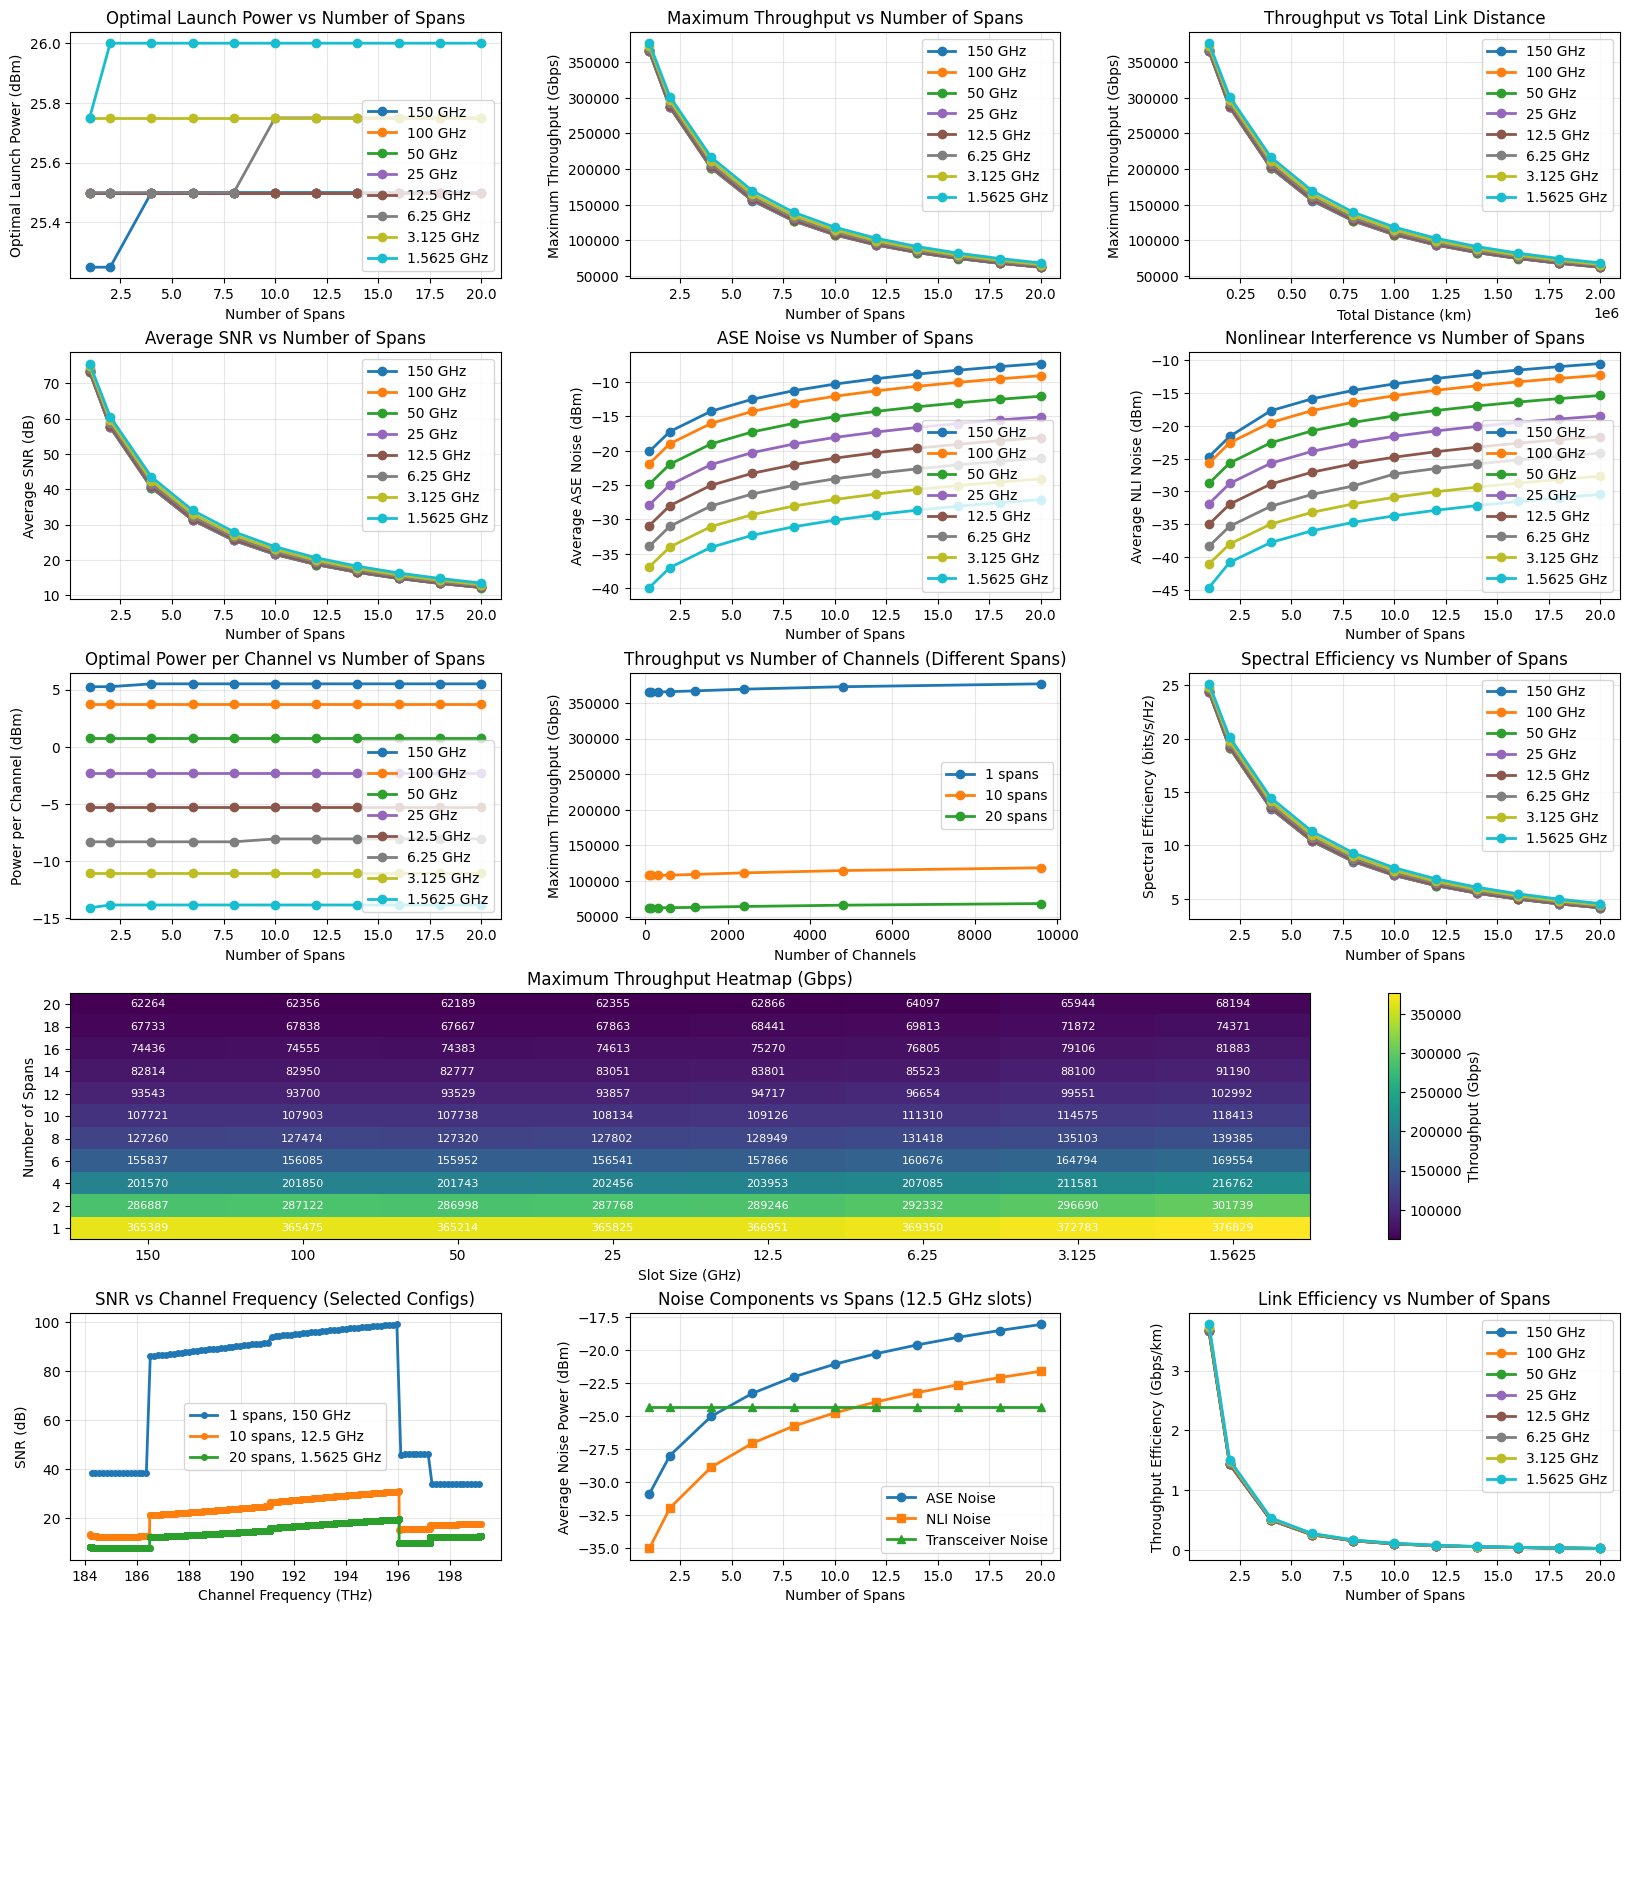

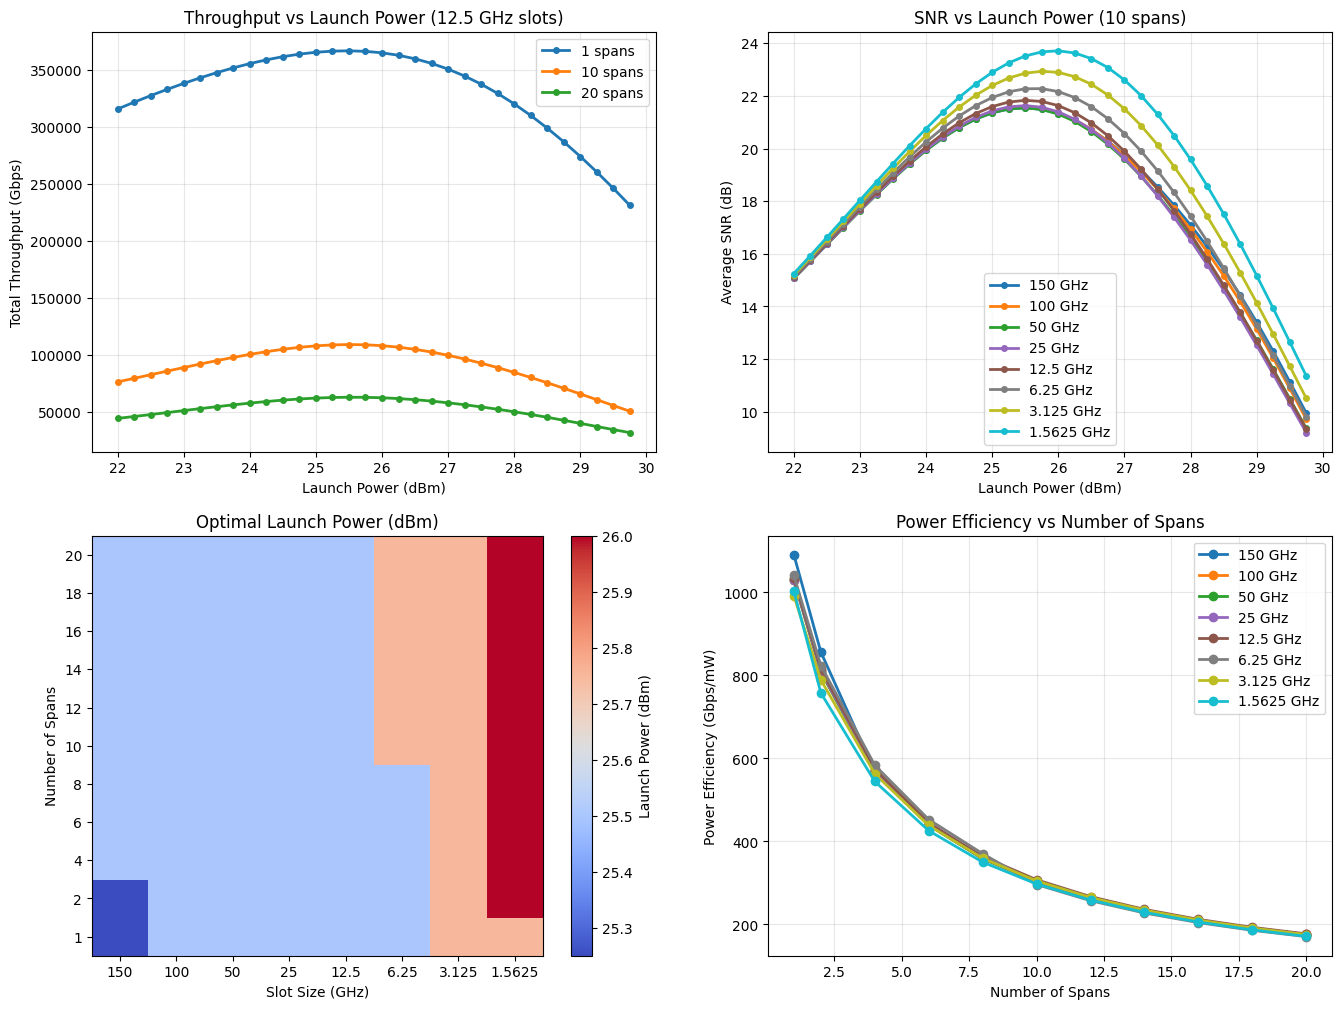

Visualization complete!
Main analysis plots created with span sweep analysis
Additional power sweep analysis plots created


In [24]:
# Enhanced visualization for fiber transmission analysis with span sweep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def create_comprehensive_analysis_plots(all_results, best_results, span_configurations, slot_sizes):
    """
    Create comprehensive visualization of fiber transmission analysis results
    including span sweep analysis
    """

    # Set up the plotting style
    plt.style.use('default')
    colors = plt.cm.tab10(np.linspace(0, 1, len(slot_sizes)))

    # Create main figure with subplots
    fig = plt.figure(figsize=(20, 24))
    gs = GridSpec(6, 3, figure=fig, hspace=0.3, wspace=0.3)

    # =================== SPAN ANALYSIS PLOTS ===================

    # Plot 1: Optimal Launch Power vs Number of Spans
    ax1 = fig.add_subplot(gs[0, 0])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        optimal_powers = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                optimal_powers.append(best_results[num_spans][slot_size]['best_power_dbm'])

        if spans:  # Only plot if we have data
            ax1.plot(spans, optimal_powers, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax1.set_xlabel('Number of Spans')
    ax1.set_ylabel('Optimal Launch Power (dBm)')
    ax1.set_title('Optimal Launch Power vs Number of Spans')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Maximum Throughput vs Number of Spans
    ax2 = fig.add_subplot(gs[0, 1])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        throughputs = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                throughputs.append(best_results[num_spans][slot_size]['max_throughput_gbps'])

        if spans:
            ax2.plot(spans, throughputs, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax2.set_xlabel('Number of Spans')
    ax2.set_ylabel('Maximum Throughput (Gbps)')
    ax2.set_title('Maximum Throughput vs Number of Spans')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Plot 3: Total Distance vs Maximum Throughput
    ax3 = fig.add_subplot(gs[0, 2])
    for i, slot_size in enumerate(slot_sizes):
        distances = []
        throughputs = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                distances.append(best_results[num_spans][slot_size]['total_distance_km'])
                throughputs.append(best_results[num_spans][slot_size]['max_throughput_gbps'])

        if distances:
            ax3.plot(distances, throughputs, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax3.set_xlabel('Total Distance (km)')
    ax3.set_ylabel('Maximum Throughput (Gbps)')
    ax3.set_title('Throughput vs Total Link Distance')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # =================== NOISE ANALYSIS PLOTS ===================

    # Plot 4: Average SNR vs Number of Spans
    ax4 = fig.add_subplot(gs[1, 0])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        avg_snrs = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                snr_data = best_results[num_spans][slot_size]['best_data']['snr_db']
                avg_snrs.append(np.mean(snr_data))

        if spans:
            ax4.plot(spans, avg_snrs, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax4.set_xlabel('Number of Spans')
    ax4.set_ylabel('Average SNR (dB)')
    ax4.set_title('Average SNR vs Number of Spans')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    # Plot 5: ASE Noise vs Number of Spans
    ax5 = fig.add_subplot(gs[1, 1])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        avg_ase = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                ase_inline = best_results[num_spans][slot_size]['best_data']['p_ase_inline']
                ase_roadm = best_results[num_spans][slot_size]['best_data']['p_ase_roadm']
                total_ase = np.mean(ase_inline + ase_roadm)
                avg_ase.append(10 * np.log10(total_ase * 1000))  # Convert to dBm

        if spans:
            ax5.plot(spans, avg_ase, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax5.set_xlabel('Number of Spans')
    ax5.set_ylabel('Average ASE Noise (dBm)')
    ax5.set_title('ASE Noise vs Number of Spans')
    ax5.grid(True, alpha=0.3)
    ax5.legend()

    # Plot 6: Nonlinear Noise vs Number of Spans
    ax6 = fig.add_subplot(gs[1, 2])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        avg_nli = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                nli_data = best_results[num_spans][slot_size]['best_data']['p_nli']
                avg_nli.append(10 * np.log10(np.mean(nli_data) * 1000))  # Convert to dBm

        if spans:
            ax6.plot(spans, avg_nli, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax6.set_xlabel('Number of Spans')
    ax6.set_ylabel('Average NLI Noise (dBm)')
    ax6.set_title('Nonlinear Interference vs Number of Spans')
    ax6.grid(True, alpha=0.3)
    ax6.legend()

    # =================== POWER ANALYSIS PLOTS ===================

    # Plot 7: Power per Channel vs Number of Spans
    ax7 = fig.add_subplot(gs[2, 0])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        powers = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                power_per_ch = best_results[num_spans][slot_size]['best_data']['power_per_channel_dbm']
                powers.append(power_per_ch)

        if spans:
            ax7.plot(spans, powers, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax7.set_xlabel('Number of Spans')
    ax7.set_ylabel('Power per Channel (dBm)')
    ax7.set_title('Optimal Power per Channel vs Number of Spans')
    ax7.grid(True, alpha=0.3)
    ax7.legend()

    # Plot 8: Number of Channels vs Throughput for Different Spans
    ax8 = fig.add_subplot(gs[2, 1])
    span_subset = [1, 5, 10, 15, 20]  # Show subset for clarity
    for span_idx, num_spans in enumerate(span_subset):
        if num_spans in best_results:
            channels = []
            throughputs = []
            for slot_size in slot_sizes:
                if slot_size in best_results[num_spans]:
                    channels.append(best_results[num_spans][slot_size]['best_data']['num_channels'])
                    throughputs.append(best_results[num_spans][slot_size]['max_throughput_gbps'])

            if channels:
                ax8.plot(channels, throughputs, 'o-',
                        label=f'{num_spans} spans', linewidth=2, markersize=6)

    ax8.set_xlabel('Number of Channels')
    ax8.set_ylabel('Maximum Throughput (Gbps)')
    ax8.set_title('Throughput vs Number of Channels (Different Spans)')
    ax8.grid(True, alpha=0.3)
    ax8.legend()

    # Plot 9: Spectral Efficiency vs Number of Spans
    ax9 = fig.add_subplot(gs[2, 2])
    for i, slot_size in enumerate(slot_sizes):
        spans = []
        spectral_efficiencies = []
        for num_spans in span_configurations:
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                spans.append(num_spans)
                throughput = best_results[num_spans][slot_size]['max_throughput_gbps']
                # Spectral efficiency in bits/s/Hz
                se = (throughput * 1e9) / (15e12)  # 15 THz total bandwidth
                spectral_efficiencies.append(se)

        if spans:
            ax9.plot(spans, spectral_efficiencies, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax9.set_xlabel('Number of Spans')
    ax9.set_ylabel('Spectral Efficiency (bits/s/Hz)')
    ax9.set_title('Spectral Efficiency vs Number of Spans')
    ax9.grid(True, alpha=0.3)
    ax9.legend()

    # =================== HEATMAPS ===================

    # Plot 10: Throughput Heatmap (Spans vs Slot Size)
    ax10 = fig.add_subplot(gs[3, :])

    # Create matrices for heatmap
    throughput_matrix = np.full((len(span_configurations), len(slot_sizes)), np.nan)

    for i, num_spans in enumerate(span_configurations):
        for j, slot_size in enumerate(slot_sizes):
            if (num_spans in best_results and
                slot_size in best_results[num_spans]):
                throughput_matrix[i, j] = best_results[num_spans][slot_size]['max_throughput_gbps']

    im = ax10.imshow(throughput_matrix, cmap='viridis', aspect='auto', origin='lower')
    ax10.set_xticks(range(len(slot_sizes)))
    ax10.set_xticklabels([f'{s}' for s in slot_sizes])
    ax10.set_yticks(range(len(span_configurations)))
    ax10.set_yticklabels([f'{s}' for s in span_configurations])
    ax10.set_xlabel('Slot Size (GHz)')
    ax10.set_ylabel('Number of Spans')
    ax10.set_title('Maximum Throughput Heatmap (Gbps)')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax10)
    cbar.set_label('Throughput (Gbps)')

    # Add text annotations
    for i in range(len(span_configurations)):
        for j in range(len(slot_sizes)):
            if not np.isnan(throughput_matrix[i, j]):
                text = ax10.text(j, i, f'{throughput_matrix[i, j]:.0f}',
                               ha="center", va="center", color="white", fontsize=8)

    # =================== DETAILED ANALYSIS PLOTS ===================

    # Plot 11: SNR Distribution for Selected Configurations
    ax11 = fig.add_subplot(gs[4, 0])

    # Select a few representative configurations
    selected_configs = [(1, slot_sizes[0]), (10, slot_sizes[len(slot_sizes)//2]), (20, slot_sizes[-1])]

    for config_idx, (num_spans, slot_size) in enumerate(selected_configs):
        if (num_spans in best_results and slot_size in best_results[num_spans]):
            snr_data = best_results[num_spans][slot_size]['best_data']['snr_db']
            ch_freqs = best_results[num_spans][slot_size]['best_data']['ch_centre_freq']

            ax11.plot(ch_freqs/1e12, snr_data, 'o-',
                     label=f'{num_spans} spans, {slot_size} GHz',
                     linewidth=2, markersize=4)

    ax11.set_xlabel('Channel Frequency (THz)')
    ax11.set_ylabel('SNR (dB)')
    ax11.set_title('SNR vs Channel Frequency (Selected Configs)')
    ax11.grid(True, alpha=0.3)
    ax11.legend()

    # Plot 12: Noise Components vs Spans (for one slot size)
    ax12 = fig.add_subplot(gs[4, 1])

    # Use middle slot size for this analysis
    ref_slot_size = slot_sizes[len(slot_sizes)//2]

    spans_data = []
    ase_data = []
    nli_data = []
    transceiver_data = []

    for num_spans in span_configurations:
        if (num_spans in best_results and ref_slot_size in best_results[num_spans]):
            spans_data.append(num_spans)

            # Get noise components
            ase_inline = np.mean(best_results[num_spans][ref_slot_size]['best_data']['p_ase_inline'])
            ase_roadm = np.mean(best_results[num_spans][ref_slot_size]['best_data']['p_ase_roadm'])
            nli = np.mean(best_results[num_spans][ref_slot_size]['best_data']['p_nli'])
            trans = np.mean(best_results[num_spans][ref_slot_size]['best_data']['transceiver_noise'])

            ase_data.append(10 * np.log10((ase_inline + ase_roadm) * 1000))
            nli_data.append(10 * np.log10(nli * 1000))
            transceiver_data.append(10 * np.log10(trans * 1000))

    if spans_data:
        ax12.plot(spans_data, ase_data, 'o-', label='ASE Noise', linewidth=2, markersize=6)
        ax12.plot(spans_data, nli_data, 's-', label='NLI Noise', linewidth=2, markersize=6)
        ax12.plot(spans_data, transceiver_data, '^-', label='Transceiver Noise', linewidth=2, markersize=6)

    ax12.set_xlabel('Number of Spans')
    ax12.set_ylabel('Average Noise Power (dBm)')
    ax12.set_title(f'Noise Components vs Spans ({ref_slot_size} GHz slots)')
    ax12.grid(True, alpha=0.3)
    ax12.legend()

    # Plot 13: Efficiency Metrics
    ax13 = fig.add_subplot(gs[4, 2])

    for i, slot_size in enumerate(slot_sizes):
        spans = []
        efficiency = []  # Gbps per km
        for num_spans in span_configurations:
            if (num_spans in best_results and slot_size in best_results[num_spans]):
                spans.append(num_spans)
                throughput = best_results[num_spans][slot_size]['max_throughput_gbps']
                distance = best_results[num_spans][slot_size]['total_distance_km']
                efficiency.append(throughput / distance if distance > 0 else 0)

        if spans:
            ax13.plot(spans, efficiency, 'o-', color=colors[i],
                     label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax13.set_xlabel('Number of Spans')
    ax13.set_ylabel('Throughput Efficiency (Gbps/km)')
    ax13.set_title('Link Efficiency vs Number of Spans')
    ax13.grid(True, alpha=0.3)
    ax13.legend()

    # =================== SUMMARY STATISTICS ===================

    # Plot 14: Summary Statistics Table
    ax14 = fig.add_subplot(gs[5, :])
    ax14.axis('off')

    # Create summary table
    summary_data = []
    headers = ['Spans', 'Distance (km)', 'Best Slot (GHz)', 'Best Power (dBm)',
               'Max Throughput (Gbps)', 'Avg SNR (dB)', 'Spectral Eff (b/s/Hz)']

    for num_spans in span_configurations:
        if num_spans in best_results:
            # Find best slot size for this span count
            best_slot = max(best_results[num_spans].keys(),
                          key=lambda k: best_results[num_spans][k]['max_throughput_gbps'])

            row_data = best_results[num_spans][best_slot]
            distance = row_data['total_distance_km']
            power = row_data['best_power_dbm']
            throughput = row_data['max_throughput_gbps']
            avg_snr = np.mean(row_data['best_data']['snr_db'])
            spec_eff = (throughput * 1e9) / (15e12)

            summary_data.append([
                num_spans, distance, best_slot, power,
                f'{throughput:.1f}', f'{avg_snr:.1f}', f'{spec_eff:.2f}'
            ])

    # if summary_data:
    #     table = ax14.table(cellText=summary_data, colLabels=headers,
    #                       cellLoc='center', loc='center')
    #     table.auto_set_font_size(False)
    #     table.set_fontsize(9)
    #     table.scale(1, 2)
    #
    #     # Style the table
    #     for i in range(len(headers)):
    #         table[(0, i)].set_facecolor('#4CAF50')
    #         table[(0, i)].set_text_props(weight='bold', color='white')
    #
    #     ax14.set_title('Summary: Best Configuration for Each Span Count',
    #                   fontsize=14, fontweight='bold', pad=20)

    #plt.tight_layout()
    return fig

# =================== ADDITIONAL ANALYSIS FUNCTIONS ===================

def plot_power_sweep_analysis(all_results, span_configurations, slot_sizes, launch_powers):
    """
    Create detailed power sweep analysis plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = plt.cm.tab10(np.linspace(0, 1, len(slot_sizes)))

    # Plot 1: Throughput vs Launch Power for different spans (one slot size)
    ax1 = axes[0, 0]
    ref_slot_size = slot_sizes[len(slot_sizes)//2]
    span_subset = [1, 5, 10, 15, 20]

    for span_idx, num_spans in enumerate(span_subset):
        if num_spans in all_results and ref_slot_size in all_results[num_spans]:
            powers = []
            throughputs = []
            for power_dbm in launch_powers:
                if power_dbm in all_results[num_spans][ref_slot_size]:
                    powers.append(power_dbm)
                    throughputs.append(all_results[num_spans][ref_slot_size][power_dbm]['total_throughput_gbps'])

            if powers:
                ax1.plot(powers, throughputs, 'o-',
                        label=f'{num_spans} spans', linewidth=2, markersize=4)

    ax1.set_xlabel('Launch Power (dBm)')
    ax1.set_ylabel('Total Throughput (Gbps)')
    ax1.set_title(f'Throughput vs Launch Power ({ref_slot_size} GHz slots)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: SNR vs Launch Power
    ax2 = axes[0, 1]
    num_spans = 10  # Fixed span count

    for i, slot_size in enumerate(slot_sizes):
        if num_spans in all_results and slot_size in all_results[num_spans]:
            powers = []
            avg_snrs = []
            for power_dbm in launch_powers:
                if power_dbm in all_results[num_spans][slot_size]:
                    powers.append(power_dbm)
                    snr_data = all_results[num_spans][slot_size][power_dbm]['snr_db']
                    avg_snrs.append(np.mean(snr_data))

            if powers:
                ax2.plot(powers, avg_snrs, 'o-', color=colors[i],
                        label=f'{slot_size} GHz', linewidth=2, markersize=4)

    ax2.set_xlabel('Launch Power (dBm)')
    ax2.set_ylabel('Average SNR (dB)')
    ax2.set_title(f'SNR vs Launch Power ({num_spans} spans)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Plot 3: Optimal power contour plot
    ax3 = axes[1, 0]

    # Create meshgrid for contour plot
    span_range = span_configurations
    slot_range = slot_sizes

    optimal_power_matrix = np.full((len(span_range), len(slot_range)), np.nan)

    for i, num_spans in enumerate(span_range):
        for j, slot_size in enumerate(slot_range):
            if (num_spans in best_results and slot_size in best_results[num_spans]):
                optimal_power_matrix[i, j] = best_results[num_spans][slot_size]['best_power_dbm']

    im = ax3.imshow(optimal_power_matrix, cmap='coolwarm', aspect='auto', origin='lower')
    ax3.set_xticks(range(len(slot_range)))
    ax3.set_xticklabels([f'{s}' for s in slot_range])
    ax3.set_yticks(range(len(span_range)))
    ax3.set_yticklabels([f'{s}' for s in span_range])
    ax3.set_xlabel('Slot Size (GHz)')
    ax3.set_ylabel('Number of Spans')
    ax3.set_title('Optimal Launch Power (dBm)')

    cbar = plt.colorbar(im, ax=ax3)
    cbar.set_label('Launch Power (dBm)')

    # Plot 4: Power efficiency
    ax4 = axes[1, 1]

    for i, slot_size in enumerate(slot_sizes):
        spans = []
        power_efficiency = []  # Gbps per mW
        for num_spans in span_configurations:
            if (num_spans in best_results and slot_size in best_results[num_spans]):
                spans.append(num_spans)
                throughput = best_results[num_spans][slot_size]['max_throughput_gbps']
                power_dbm = best_results[num_spans][slot_size]['best_power_dbm']
                power_mw = 10**(power_dbm/10)
                power_efficiency.append(throughput / power_mw)

        if spans:
            ax4.plot(spans, power_efficiency, 'o-', color=colors[i],
                    label=f'{slot_size} GHz', linewidth=2, markersize=6)

    ax4.set_xlabel('Number of Spans')
    ax4.set_ylabel('Power Efficiency (Gbps/mW)')
    ax4.set_title('Power Efficiency vs Number of Spans')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    #plt.tight_layout()
    return fig

# Main visualization function call
if 'all_results' in globals() and 'best_results' in globals():
    # Create main comprehensive plot
    main_fig = create_comprehensive_analysis_plots(all_results, best_results,
                                                  span_configurations, slot_sizes)

    # Create additional power sweep analysis
    power_fig = plot_power_sweep_analysis(all_results, span_configurations,
                                         slot_sizes, launch_powers)

    # Show plots
    plt.show()

    print("Visualization complete!")
    print("Main analysis plots created with span sweep analysis")
    print("Additional power sweep analysis plots created")
else:
    print("Error: Results data not found. Please run the analysis first.")